# Authorencoding Training and serving

## Outline


1. Upload the processed data to S3.
2. Train a chosen model.
3. Test the trained model
4. Deploy the trained model.
5. Use the deployed model to server a website.
 - Create Lambda role
 - Create Lambda function
 - Create API GATEWAY
 - Serve



### Uploading the training data


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [206]:
import os
data_dir = '../../data/processed/' # The folder where data iterator are stored
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)
    print('Created: ', data_dir)
    
import sys
import pickle
sys.path.insert(1, './train/')

In [207]:
import sagemaker
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
#prefix = 'toxic/data'
prefix = 'authorencoder/data'
role = sagemaker.get_execution_role()

In [208]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

## Training the model

In [96]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train_nlp.py",
                    source_dir="train",
                    role=role,
                    framework_version='1.3.1', #1.0.0
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'epochs': 15#,
                    #    'hidden_dim': 100,
                    })

In [97]:
estimator.fit({'training': input_data})

2020-02-05 22:01:15 Starting - Starting the training job...
2020-02-05 22:01:16 Starting - Launching requested ML instances......
2020-02-05 22:02:21 Starting - Preparing the instances for training......
2020-02-05 22:03:30 Downloading - Downloading input data......
2020-02-05 22:04:30 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-02-05 22:04:51,035 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-02-05 22:04:51,038 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-02-05 22:04:51,052 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-02-05 22:04:51,053 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-02-05 22:04:51,478 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py


2020-02-05 22:05:28 Uploading - Uploading generated training model
2020-02-05 22:05:28 Completed - Training job completed
Training seconds: 118
Billable seconds: 118


In [98]:
#estimator.delete_endpoint

## Step 5: Testing the model

As mentioned at the top of this notebook, we will be testing this model by first deploying it and then sending the testing data to the deployed endpoint. We will do this so that we can make sure that the deployed model is working correctly.

## Deploy the model for testing

When the built-in inference code is run it must import the `model_fn()` method from the `train.py` file. This is why the training code is wrapped in a main guard ( ie, `if __name__ == '__main__':` )



In [99]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------!

In [100]:
data_dir = '../../data/processed/'
data_name = 'longest10.json'
prefix = data_name[:-5]

file_embedding = prefix + '_embedding.pkl'
file_dict = prefix + '_dict.pkl'
file_tokenized_train_data = prefix + '_train.pkl'
file_tokenized_valid_data = prefix + '_valid.pkl'

In [101]:
import pickle
import torch
from siamese_triplet import BalancedBatchSampler, data_to_Iterator

#Turn dataset into Loader
train_Loader=data_to_Iterator(data_dir, file_tokenized_train_data, n_classes=10, n_samples=10, sampler= True)
valid_Loader=data_to_Iterator(data_dir, file_tokenized_valid_data, n_classes=10, n_samples=10, sampler= True)

In [102]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

import numpy as np
    
def extract_embeddings(dataloader, emb_dim, is_cuda_available):
    with torch.no_grad():

        embeddings = np.zeros((len(dataloader.dataset), emb_dim))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for poems, target in dataloader:
            poems = poems.squeeze()
            poems_le= len(poems)
            if is_cuda_available:
                poems = poems.cuda()

            #embeddings[k:k+poems_le] = model.get_embedding(poems).data.cpu().numpy()
            print(poems.size())
            embeddings[k:k+poems_le] = predictor.predict(poems)
            
            labels[k:k+poems_le] = target.numpy()
            k += poems_le
    return embeddings, labels

def plot_embeddings(embeddings, targets, xlim=None, ylim=None,  save_plot= None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)
    #if save_plot!=None:
    #    plt.savefig('../media/'+save_plot)

In [103]:
valid_embeddings_otl, valid_labels_otl = extract_embeddings(valid_Loader, 2, False)
train_embeddings_otl, train_labels_otl = extract_embeddings(train_Loader, 2, False)

torch.Size([88, 101])
torch.Size([100, 101])
torch.Size([100, 101])
torch.Size([100, 101])
torch.Size([100, 101])
torch.Size([100, 101])


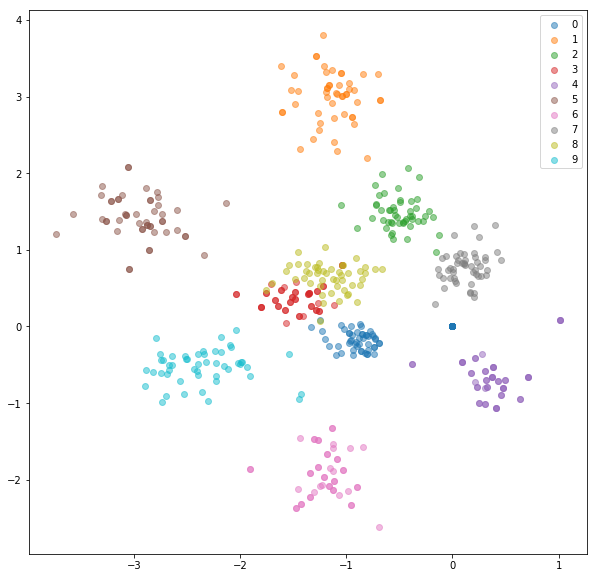

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
plot_embeddings(train_embeddings_otl, train_labels_otl,save_plot='testing.png')

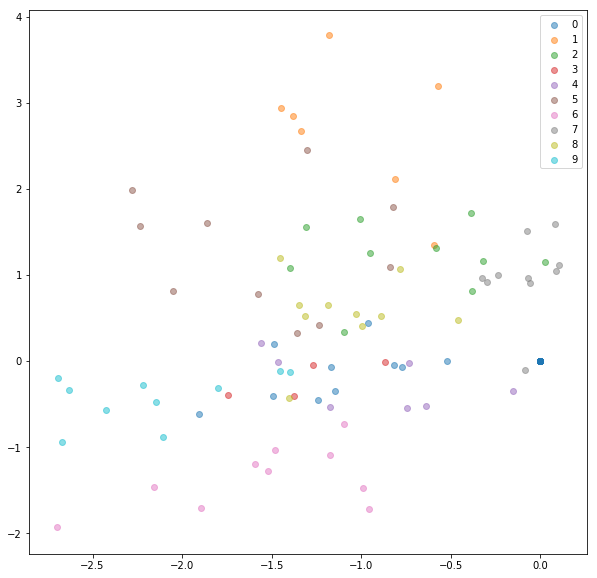

In [105]:
plot_embeddings(valid_embeddings_otl, valid_labels_otl,save_plot='testing.png')

In [106]:
from sklearn.neighbors import KNeighborsClassifier as KNC
KNN = KNC(n_neighbors=3)
KNN.fit(train_embeddings_otl, train_labels_otl)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [107]:
predictions= KNN.predict(valid_embeddings_otl)
predictions

array([8., 2., 8., 7., 8., 8., 8., 8., 8., 0., 0., 0., 4., 0., 3., 0., 3.,
       1., 2., 1., 1., 2., 1., 1., 2., 2., 8., 7., 2., 8., 2., 2., 2., 2.,
       9., 9., 9., 9., 0., 0., 9., 9., 9., 9., 6., 6., 9., 6., 6., 0., 6.,
       9., 6., 6., 0., 2., 7., 7., 7., 2., 7., 2., 7., 7., 9., 0., 0., 0.,
       9., 8., 0., 0., 0., 3., 0., 0., 0., 0., 8., 1., 3., 2., 5., 2., 3.,
       3., 5., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [108]:
KNN.score(valid_embeddings_otl,valid_labels_otl)

0.725925925925926

In [109]:
int(KNN.predict(valid_embeddings_otl[0].reshape(1, -1)).item())

8

In [110]:
author_encoder_path = os.path.join('./serve/', 'authorencoder.pkl')
with open(author_encoder_path, 'wb') as f:
    pickle.dump([train_embeddings_otl.tolist(), train_labels_otl.tolist()], f ) 

In [139]:
author_encoder_path = os.path.join('./serve/', 'authorencoder.pkl')
with open(author_encoder_path, 'rb') as f:
    train_embeddings_otl, train_labels_otl= pickle.load( f ) 

from sklearn.neighbors import KNeighborsClassifier as KNC
KNN = KNC(n_neighbors=3)
KNN.fit(train_embeddings_otl, train_labels_otl)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

## Preparing files for serving

In [111]:
import re

chars_to_keep=".,'\n?!"

to_keep= ""
for i in chars_to_keep:
    to_keep+= i+'|'
    
rep_special_chars= re.compile("[^\w\n|"+ (to_keep[:-1])+ "]|_")


def wspace_schars(review, no_white_space = False,
                  no_newlines= False):
    """
    TODO
    """
    # Subs special chars by white space except chars_to_keep
    text=rep_special_chars.sub(' ', review)
    if no_white_space:
        text = re.sub('\n+', '\n',text) # Remove consecutive breaklines
    if no_newlines:
        text = re.sub(' +', ' ',text) # Remove consecutive white space
    return text


sentence = 'Always look at the bright side of life? But, yeah!'.lower()
 
    
FIX_WORD_LENGTH = 101
def pad_to_n(ls, n = FIX_WORD_LENGTH):
    """ls list to be cut/padded to length n"""
    ls= ls[:n]
    if len(ls)<n: ls=(['<pad>']*(n-len(ls))) + ls
    return ls


def text_to_words(text):     
    text = wspace_schars(text).lower()
    words= re.findall(r"[\w']+|[.,!?\n ]", text)
    words= pad_to_n(words)
    return words

def tokenize(word_dict, text):   
    words = text_to_words(text)
    print(words)
    words=[word_dict[w] if w in word_dict else word_dict['<unk>'] for w in words]
    return words

In [112]:
word_dict_path = os.path.join(data_dir, file_dict) 
with open(word_dict_path, 'rb') as f:
        word_dict = pickle.load(f)

In [118]:
test_sentence = "Always look at the bright side"
tensor = torch.tensor(tokenize(word_dict, test_sentence))
poem = tensor.unsqueeze(0).unsqueeze(0)

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'always', ' ', 'look', ' ', 'at', ' ', 'the', ' ', 'bright', ' ', 'side']


In [119]:
author_encoder_path = os.path.join('./serve/', 'authorencoder.pkl')
with open(author_encoder_path, 'rb') as f:
    train_embeddings_otl, train_labels_otl= pickle.load( f ) 

from sklearn.neighbors import KNeighborsClassifier as KNC
KNN = KNC(n_neighbors=3)
KNN.fit(train_embeddings_otl, train_labels_otl)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [122]:
output = predictor.predict(poem)
int(KNN.predict((output).reshape(1, -1)).item())

0

Toxic labels stats 

In [95]:
#estimator.delete_endpoint()

### Delete the endpoint

Of course, just like in the XGBoost notebook, once we've deployed an endpoint it continues to run until we tell it to shut down. Since we are done using our endpoint for now, we can delete it.

In [26]:
estimator.delete_endpoint()

## Step 6 (again) - Deploy the model for the web app


We will store the code that we write in the `serve` directory. Provided in this directory is the `model.py` file that we used to construct our model, a `utils.py` file which contains the `review_to_words` and `convert_and_pad` pre-processing functions which we used during the initial data processing, and `predict.py`, the file which will contain our custom inference code. Note also that `requirements.txt` is present which will tell SageMaker what Python libraries are required by our custom inference code.

When deploying a PyTorch model in SageMaker, you are expected to provide four functions which the SageMaker inference container will use.
 - `model_fn`: This function is the same function that we used in the training script and it tells SageMaker how to load our model.
 - `input_fn`: This function receives the raw serialized input that has been sent to the model's endpoint and its job is to de-serialize and make the input available for the inference code.
 - `output_fn`: This function takes the output of the inference code and its job is to serialize this output and return it to the caller of the model's endpoint.
 - `predict_fn`: The heart of the inference script, this is where the actual prediction is done and is the function which you will need to complete.

For the simple website that we are constructing during this project, the `input_fn` and `output_fn` methods are relatively straightforward. We only require being able to accept a string as input and we expect to return a single value as output. You might imagine though that in a more complex application the input or output may be image data or some other binary data which would require some effort to serialize.

### Writing inference code

Before writing our custom inference code, we will begin by taking a look at the code which has been provided.

As mentioned earlier, the `model_fn` method is the same as the one provided in the training code and the `input_fn` and `output_fn` methods are very simple and your task will be to complete the `predict_fn` method. Make sure that you save the completed file as `predict.py` in the `serve` directory.

**TODO**: Complete the `predict_fn()` method in the `serve/predict.py` file.

### Deploying the model

Now that the custom inference code has been written, we will create and deploy our model. To begin with, we need to construct a new PyTorchModel object which points to the model artifacts created during training and also points to the inference code that we wish to use. Then we can call the deploy method to launch the deployment container.

**NOTE**: The default behaviour for a deployed PyTorch model is to assume that any input passed to the predictor is a `numpy` array. In our case we want to send a string so we need to construct a simple wrapper around the `RealTimePredictor` class to accomodate simple strings. In a more complicated situation you may want to provide a serialization object, for example if you wanted to sent image data.

In [ ]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.3.1',
                     entry_point='predict_nlp.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)

In [ ]:
shakespeare_apochrypha = """O, that infected moisture of his eye,
O, that false fire which in his cheek so glowed,
O, that forced thunder from his heart did fly,
O, that sad breath his spungy lungs bestowed,
O, all that borrowed motion seeming owed,
Would yet again betray the fore-betrayed,
And new pervert a reconciled maid!"""

In [ ]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

In [230]:
prueba = predictor.predict(shakespeare_apochrypha)

In [231]:
print(prueba.decode('utf-8'))



Beowulf Anonimous


In [232]:
#predictor.delete_endpoint
predictor.endpoint

'pytorch-inference-2020-02-06-20-38-05-545'

### TODO: Crosschek on validation set. 

## Step 7 Use the model for the web app


So far we have been accessing our model endpoint by constructing a predictor object which uses the endpoint and then just using the predictor object to perform inference. What if we wanted to create a web app which accessed our model? The way things are set up currently makes that not possible since in order to access a SageMaker endpoint the app would first have to authenticate with AWS using an IAM role which included access to SageMaker endpoints. However, there is an easier way! We just need to use some additional AWS services.


### Setting up a Lambda function

The first thing we are going to do is set up a Lambda function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

#### Part A: Create an IAM Role for the Lambda function

Since we want the Lambda function to call a SageMaker endpoint, we need to make sure that it has permission to do so. To do this, we will construct a role that we can later give the Lambda function.

Using the AWS Console, navigate to the **IAM** page and click on **Roles**. Then, click on **Create role**. Make sure that the **AWS service** is the type of trusted entity selected and choose **Lambda** as the service that will use this role, then click **Next: Permissions**.

In the search box type `sagemaker` and select the check box next to the **AmazonSageMakerFullAccess** policy. Then, click on **Next: Review**.

Lastly, give this role a name. Make sure you use a name that you will remember later on, for example `LambdaAuthorEncoder`. Then, click on **Create role**.

#### Part B: Create a Lambda function

Now it is time to actually create the Lambda function.

Using the AWS Console, navigate to the AWS Lambda page and click on **Create a function**. When you get to the next page, make sure that **Author from scratch** is selected. Now, name your Lambda function, using a name that you will remember later on, for example `authorencoder_func`. Make sure that the **Python 3.6** runtime is selected and then choose the role that you created in the previous part. Then, click on **Create Function**.

On the next page you will see some information about the Lambda function you've just created. If you scroll down you should see an editor in which you can write the code that will be executed when your Lambda function is triggered. In our example, we will use the code below. 

```python
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = '**ENDPOINT NAME HERE**',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

Once you have copy and pasted the code above into the Lambda code editor, replace the `**ENDPOINT NAME HERE**` portion with the name of the endpoint that we deployed earlier. You can determine the name of the endpoint using the code cell below.

Once you have added the endpoint name to the Lambda function, click on **Save**. Your Lambda function is now up and running. Next we need to create a way for our web app to execute the Lambda function.

### Setting up API Gateway

Now that our Lambda function is set up, it is time to create a new API using API Gateway that will trigger the Lambda function we have just created.

Using AWS Console, navigate to **Amazon API Gateway** and then click on **Get started**.

On the next page, make sure that **New API** is selected and give the new api a name, for example, `authorencoder_api`. Then, click on **Create API**.

Now we have created an API, however it doesn't currently do anything. What we want it to do is to trigger the Lambda function that we created earlier.

Select the **Actions** dropdown menu and click **Create Method**. A new blank method will be created, select its dropdown menu and select **POST**, then click on the check mark beside it.

For the integration point, make sure that **Lambda Function** is selected and click on the **Use Lambda Proxy integration**. This option makes sure that the data that is sent to the API is then sent directly to the Lambda function with no processing. It also means that the return value must be a proper response object as it will also not be processed by API Gateway.

Type the name of the Lambda function you created earlier into the **Lambda Function** text entry box and then click on **Save**. Click on **OK** in the pop-up box that then appears, giving permission to API Gateway to invoke the Lambda function you created.

The last step in creating the API Gateway is to select the **Actions** dropdown and click on **Deploy API**. You will need to create a new Deployment stage and name it anything you like, for example `prod`.

You have now successfully set up a public API to access your SageMaker model. Make sure to copy or write down the URL provided to invoke your newly created public API as this will be needed in the next step. This URL can be found at the top of the page, highlighted in blue next to the text **Invoke URL**.

## Step 4: Deploying our web app

Now that we have a publicly available API, we can start using it in a web app.

In the `website` folder there should be a file called `index.html`. Download the file to your computer and open that file up in a text editor of your choice. There should be a line which contains **\*\*REPLACE WITH PUBLIC API URL\*\***. Replace this string with the url that you wrote down in the last step and then save the file.

Now, if you open `index.html` on your local computer, your browser will behave as a local web server and you can use the provided site to interact with your SageMaker model.

If you'd like to go further, you can host this html file anywhere you'd like.

> **Important Note** In order for the web app to communicate with the SageMaker endpoint, the endpoint has to actually be deployed and running. This means that you are paying for it. Make sure that the endpoint is running when you want to use the web app but that you shut it down when you don't need it, otherwise you will end up with a surprisingly large AWS bill.


### Delete the endpoint

Remember to always shut down your endpoint if you are no longer using it. You are charged for the length of time that the endpoint is running so if you forget and leave it on you could end up with an unexpectedly large bill.

In [108]:
predictor.delete_endpoint()